# Vehicle routing problem als mip

Wir betrachten hier das vehicle routing problem.

In [1]:
# installieren von mip --- wenn Sie das lokal ausführen, können Sie den Befehl evtl weglassen
!pip install mip

import mip
import random
import math

## Zufallsinstanz

wir erzeugen eine Zufallsinstanz mit euklidischen Distanzen

In [2]:
def rnd_instance(n=15,k=3):
    positions=[(random.random(),random.random()) for _ in range(n+1)]
    positions[0]=(0.5,0.5)  ## wir setzen das Depot in die Mitte
    d=[random.randint(1,3) for _ in positions]
    return positions,d

n=10 # Anzahl Kunden
k=3  # Anzahl Lieferwagen
q=10 # Kapazität der Lieferwagen
positions,d=rnd_instance(n=n,k=k)

Visualisierungscode -- der kann getrost ignoriert werden. 

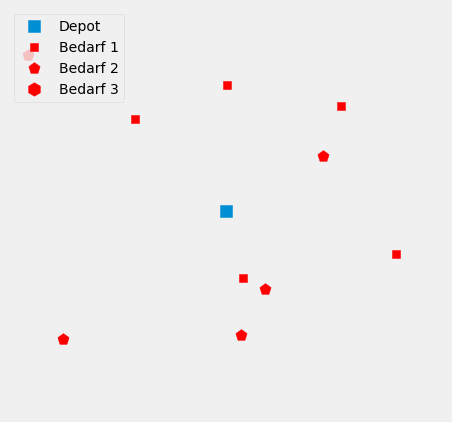

In [3]:
import matplotlib.pyplot as plt  # für Grafikausgabe
### Wir benutzen das fivethirtyeight style, damit die plots ein bisschen hübscher aussehen
### könnte auch weggelassen werden
plt.style.use('fivethirtyeight')

def show(positions,d,x=None):
    plt.figure(figsize=(7,7))
    depot=positions[0]
    plt.scatter([depot[0]],[depot[1]],s=150,marker='s',label='Depot')
    markers={1:'s',2:'p',3:'h'}
    marker_sizes={1:80,2:140,3:180}
    for customer,demand in zip(positions[1:],d[1:]):
        plt.scatter([customer[0]],[customer[1]],color='r',s=marker_sizes[demand],marker=markers[demand])
    
    for bogus in [1,2,3]:
        plt.scatter([bogus*100],[bogus*100],color='r',s=marker_sizes[bogus],marker=markers[bogus],label="Bedarf {}".format(bogus))
        
    if x is not None:
        n=len(positions)
        E=[(u,v) for u in range(n+1) for v in range(n) if u!=v]
        for xx,e in zip(x,E):
            if xx.x==1:
                u,v=e
                plt.plot([positions[u][0],positions[v][0]],[positions[u][1],positions[v][1]],'k',zorder=-1,alpha=0.5,linewidth=2) 

    margin=0.05
    plt.xlim(-margin,1+margin)
    plt.ylim(-margin,1+margin)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.show()   

show(positions,d)

## Das mip


\begin{align}
\min \sum_{e\in E}c_ex_e & & (1)\\
\sum_{e\in\delta^+(0)}x_e\leq k && (2)\\
\sum_{e\in\delta^-(v)}x_e=1 & \quad\text{für alle }v\in C & (3)\\
\sum_{e\in\delta^-(v)}x_e=\sum_{e\in\delta^+(v)}x_e & \quad\text{für alle }v\in C_0 & (4) \\
y_u+d_u-y_v\leq (1-x_{(u,v)})2q & \quad\text{für alle }(u,v)\in E\setminus\delta^+(0)& (5)\\
0\leq y_v\leq q&\quad\text{für alle }v\in C_0& (6)\\
x_e\in\{0,1\}&\quad\text{für alle }e\in E & (7)
\end{align}

Bevor wir das Modell instantiieren, beschaffen wir uns noch die Menge aller Kunden, die Menge aller Kunden plus Depot und die Menge aller Kanten. Zusätzlich definieren wir uns Methoden für $\delta^+(v)$ und $\delta^-(v)$.

In [4]:
C0=range(1,n+1) # Menge der Kunden
C=range(n+1)   # Menge Kunden+Depot, das Depot hat Nr 0
# die Kantenmenge
E=[(u,v) for u in range(n+1) for v in range(n+1) if u!=v]

# Hilfsfunktionen: Indizies der ein- bzw ausgehenden Kanten bei einer Ecke v
def ingoing_edges(v):
    return [i for i,e in enumerate(E) if e[1]==v]

def outgoing_edges(v):
    return [i for i,e in enumerate(E) if e[0]==v]

m=mip.Model()

<code>enumerate</code> ist eine praktische eingebaute Methode. Zurückgeliefert werden Paare von (Index, Listeninhalt). Oben werden nach und nach Paare (i,e) zurück gegeben, wobei e eine Kante in E ist und i eben deren Position in der Liste E.

Als nächstes führen wir die Variablen ein, gleich mit den nötigen Schranken $(6)$.

In [5]:
# die Variablen
x=[m.add_var(var_type=mip.BINARY) for _ in E]
y=[m.add_var(lb=0,ub=q) for _ in C]

Die Kosten von $(u,v)$ ergeben sich einfach aus der Distanz in der Ebene. Also definieren wir eine Methode, die Distanz für $(u,v)$ ermittelt.

In [6]:
def L2_dist(p,q):
    px,py=p
    qx,qy=q
    return math.sqrt((px-qx)**2+(py-qy)**2)

def dist(e):
    """berechnet die Euklidische Länge der Kante e=(u,v)"""
    u,v=e
    return L2_dist(positions[u],positions[v])

# Zielfunktion
m.objective=mip.minimize(mip.xsum(dist(e)*x[i] for i,e in enumerate(E)))

Höchstens k Lieferwagen starten am Depot (2):

In [7]:
m+=mip.xsum(x[i] for i in outgoing_edges(0))<=k

Jeder Kunde muss bedient werden (3):

In [8]:
for v in C0:
    m+=mip.xsum(x[i] for i in ingoing_edges(v))==1

Wenn ein Lieferwagen beim Kunden oder Depot $v$ anlangt, muss er dort auch wieder abfahren (4):

In [9]:
for v in C:
    m+=mip.xsum(x[i] for i in ingoing_edges(v))-mip.xsum(x[i] for i in outgoing_edges(v))==0

Jeder Lieferwagen, der einen Kunden anfährt, muss auch genügend Kapazität für den Kunden haben (5):

In [10]:
for i,e in enumerate(E):
    u,v=e
    if u!=0:  # schließe Kanten aus, die aus dem Depot herausgehen
        m+=y[u]+d[u]-y[v]<= (1-x[i])*2*q

OptimizationStatus.OPTIMAL


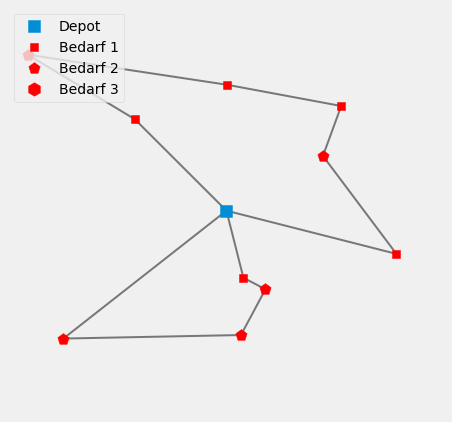

In [11]:
status=m.optimize()  # kann länger dauern....
print(status)
show(positions,d,x)